In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [3]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
# MNIST IMAGE --> Tensors

In [5]:
transform = transforms.ToTensor()

In [6]:
train_data = datasets.MNIST(root='../Data', train=True, download=True, transform=transform)

In [7]:
test_data = datasets.MNIST(root='../Data', train=False, download=True, transform=transform)

In [8]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: ../Data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [9]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: ../Data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [10]:
image, label = train_data[0]

In [11]:
image, label

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

In [12]:
image.shape

torch.Size([1, 28, 28])

In [13]:
label

5

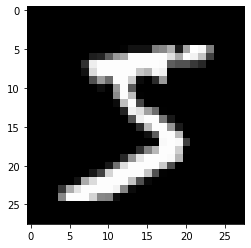

In [14]:
plt.imshow(train_data[0][0].reshape(28, 28), cmap="gray")

In [15]:
torch.manual_seed(101)

train_loader = DataLoader(train_data, batch_size=100, shuffle=True)

test_loader = DataLoader(test_data, batch_size=500, shuffle=True)

In [16]:
from torchvision.utils import make_grid
np.set_printoptions(formatter=dict(int=lambda x: f'{x:4}')) # to widen the printed array

In [17]:
# first batch
for images, labels in train_loader:
    break

In [18]:
images.shape

torch.Size([100, 1, 28, 28])

In [19]:
print('Labels: ', labels[:12].numpy())

Labels:  [   0    5    7    8    6    7    9    7    1    3    8    4]


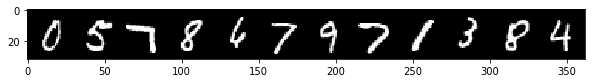

In [20]:
# Print the first 12 images
im = make_grid(images[:12], nrow=12)  # the default nrow is 8
plt.figure(figsize=(10,4))
# We need to transpose the images from CWH to WHC
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

## Define the model

In [21]:
class MultilayerPerceptron(nn.Module):
    def __init__(self, in_sz=784, out_sz=10, layers=[120,84]):
        super().__init__()
        self.fc1 = nn.Linear(in_sz,layers[0])
        self.fc2 = nn.Linear(layers[0],layers[1])
        self.fc3 = nn.Linear(layers[1],out_sz)
    
    def forward(self,X):
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return F.log_softmax(X, dim=1)

In [22]:
torch.manual_seed(101)
model = MultilayerPerceptron()
model

MultilayerPerceptron(
  (fc1): Linear(in_features=784, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [23]:
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')

In [24]:
count_parameters(model)

 94080
   120
 10080
    84
   840
    10
______
105214


### Define loss function & optimizer

In [25]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

## Flatten the training data

In [26]:
for images, labels in train_loader:
    print('Batch shape: ', images.size())
    break

Batch shape:  torch.Size([100, 1, 28, 28])


In [27]:
images.view(100, -1).size()

torch.Size([100, 784])

### Train the model

In [28]:
import time
start_time = time.time()

epochs = 10
train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    # Run the training batches
    for b, (X_train, y_train) in enumerate(train_loader):
        b+=1
        
        # Apply the model
        y_pred = model(X_train.view(100, -1))  # Here we flatten X_train
        loss = criterion(y_pred, y_train)
 
        # Tally the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Print interim results
        if b%200 == 0:
            print(f'epoch: {i:2}  batch: {b:4} [{100*b:6}/60000]  loss: {loss.item():10.8f}  \
accuracy: {trn_corr.item()*100/(100*b):7.3f}%')
    
    # Update train loss & accuracy for the epoch
    train_losses.append(loss)
    train_correct.append(trn_corr)
        
    # Run the testing batches
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):

            # Apply the model
            y_val = model(X_test.view(500, -1))  # Here we flatten X_test

            # Tally the number of correct predictions
            predicted = torch.max(y_val.data, 1)[1] 
            tst_corr += (predicted == y_test).sum()
    
    # Update test loss & accuracy for the epoch
    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)
        
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed            

epoch:  0  batch:  200 [ 20000/60000]  loss: 0.35145184  accuracy:  82.675%
epoch:  0  batch:  400 [ 40000/60000]  loss: 0.32269004  accuracy:  87.368%
epoch:  0  batch:  600 [ 60000/60000]  loss: 0.31318703  accuracy:  89.522%
epoch:  1  batch:  200 [ 20000/60000]  loss: 0.13659216  accuracy:  94.970%
epoch:  1  batch:  400 [ 40000/60000]  loss: 0.07502631  accuracy:  95.153%
epoch:  1  batch:  600 [ 60000/60000]  loss: 0.16193044  accuracy:  95.338%
epoch:  2  batch:  200 [ 20000/60000]  loss: 0.06578723  accuracy:  96.620%
epoch:  2  batch:  400 [ 40000/60000]  loss: 0.09226639  accuracy:  96.710%
epoch:  2  batch:  600 [ 60000/60000]  loss: 0.09763321  accuracy:  96.773%
epoch:  3  batch:  200 [ 20000/60000]  loss: 0.03403758  accuracy:  97.530%
epoch:  3  batch:  400 [ 40000/60000]  loss: 0.08453932  accuracy:  97.498%
epoch:  3  batch:  600 [ 60000/60000]  loss: 0.18677305  accuracy:  97.535%
epoch:  4  batch:  200 [ 20000/60000]  loss: 0.08201010  accuracy:  98.005%
epoch:  4  b

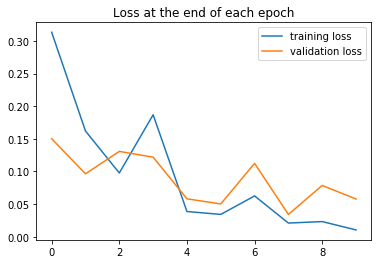

In [29]:
plt.plot(train_losses, label='training loss')
plt.plot(test_losses, label='validation loss')
plt.title('Loss at the end of each epoch')
plt.legend();

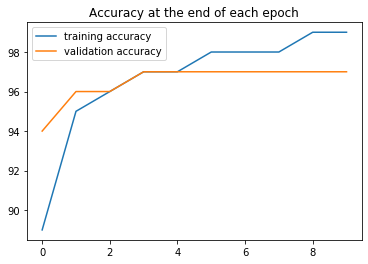

In [30]:
plt.plot([t/600 for t in train_correct], label='training accuracy')
plt.plot([t/100 for t in test_correct], label='validation accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend();

## Evaluate Test Data

In [36]:
print(test_correct) # contains the results of all 10 epochs
print()
print(f'Test accuracy: {test_correct[-1].item()*100/10000:.3f}%') # print the most recent result as a percent

[tensor(9439), tensor(9627), tensor(9698), tensor(9723), tensor(9734), tensor(9758), tensor(9778), tensor(9767), tensor(9780), tensor(9776)]

Test accuracy: 97.760%


In [37]:
# Extract the data all at once, not in batches
test_load_all = DataLoader(test_data, batch_size=10000, shuffle=False)

In [40]:
with torch.no_grad():
    correct = 0
    for X_test, y_test in test_load_all:
        y_val = model(X_test.view(len(X_test), -1)) # pass in a flattened view of X_test
        predicted = torch.max(y_val, 1)[1]
        correct += (predicted == y_test).sum()
print(f'Test accuracy: {correct.item()}/{len(test_data)} = {correct.item()*100/(len(test_data)):7.3f}%')

Test accuracy: 9776/10000 =  97.760%


### Display the confusion matrix

In [41]:
# print a row of values for reference
np.set_printoptions(formatter=dict(int=lambda x: f'{x:4}'))
print(np.arange(10).reshape(1,10))
print()

# print the confusion matrix
print(confusion_matrix(predicted.view(-1), y_test.view(-1)))

[[   0    1    2    3    4    5    6    7    8    9]]

[[ 971    0    6    1    0    3    6    0    4    1]
 [   0 1128    4    0    0    0    3    2    0    4]
 [   0    0 1002    4    6    0    0    8    3    0]
 [   3    2    6  993    0   22    1    0   10    3]
 [   1    0    1    0  953    2    6    1    0    3]
 [   1    0    0    2    0  851    4    0    3    2]
 [   0    0    2    0    4    6  935    0    1    0]
 [   0    1    8    5    3    3    0 1011    5    5]
 [   2    4    3    3    2    4    3    2  945    4]
 [   2    0    0    2   14    1    0    4    3  987]]
